In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pystan
%matplotlib inline

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/carlson9/KocPython2020/master/homework/trend2.csv").dropna().reset_index(drop=True)
df.tail()

,country,year,church2,cc,gini_net,rgdpl
583,United States,2003,31.00000,United States,37.16354,39.79302
584,United States,2004,25.05188,United States,37.20000,40.91001
585,United States,2005,31.42520,United States,37.08701,42.53482
586,United States,2006,29.70013,United States,36.87890,43.25840
587,United States,2008,26.67819,United States,36.02488,43.34071


In [3]:
df.columns = df.columns.map(str.strip)
df["country"] = df["country"].map(str.strip)
country_list = df["country"].unique()
no_of_countries = len(country_list)
look_up = dict(zip(country_list, range(no_of_countries)))
country = df['ccode'] = df["country"].replace(look_up).values
religiosity_measure = df["church2"].values #tolist
inequality_measure = df["gini_net"].values #tolist
rgdpl = df["rgdpl"].values #tolist
df.head()

,country,year,church2,cc,gini_net,rgdpl,ccode
0,Australia,1965,26.182790,Australia,29.16514,15.23929,0
1,Australia,1967,24.744380,Australia,29.50664,16.25018,0
2,Australia,1979,4.442971,Australia,25.75894,21.58357,0
3,Australia,1981,27.626460,Australia,28.10000,22.46979,0
4,Australia,1984,18.099700,Australia,28.80875,23.45019,0


In [4]:
group = df.groupby('ccode')
codelist = group.apply(lambda x: x['country'].unique())
codelist

ccode
0              [Australia]
1                [Austria]
2                [Belgium]
3               [Bulgaria]
4                 [Canada]
5                  [Chile]
6                 [Cyprus]
7         [Czech Republic]
8                [Denmark]
9                [Estonia]
10               [Finland]
11                [France]
12               [Germany]
13                [Greece]
14               [Hungary]
15               [Ireland]
16                [Israel]
17                 [Italy]
18                 [Japan]
19    [Korea, Republic of]
20                [Latvia]
21            [Luxembourg]
22           [Netherlands]
23           [New Zealand]
24                [Norway]
25           [Philippines]
26                [Poland]
27              [Portugal]
28    [Russian Federation]
29       [Slovak Republic]
30              [Slovenia]
31                 [Spain]
32                [Sweden]
33                [Turkey]
34               [Ukraine]
35        [United Kingdom]
36         [United Sta

In [5]:
randommodel = """
data {
  int<lower=0> N; 
  int<lower=0> J; 
  int<lower=1,upper=J> country[N]; 
  vector[N] y;
  vector[N] x_rgpdl;
  vector[N] x_inequality;
}
parameters {
  vector[J] a;
  real mu_a;
  real<lower=0,upper=100> sigma_a;
  vector[2] b;
  real<lower=0,upper=100> sigma_y;
}
transformed parameters {
  vector[N] y_hat;
  vector[N] m;
  for (i in 1:N) {
    m[i] = a[country[i]] + x_inequality[i] * b[1];
    y_hat[i] = m[i] + x_rgpdl[i] * b[2];
  }
}
model {
  sigma_a ~ uniform(0, 100);
  a ~ normal(mu_a, sigma_a);
  b[1] ~ normal(0,1);
  //b[1] ~ beta(661,661);
  b[2] ~ normal(0,1);
  //b[2] ~ beta(661,661);
  sigma_y ~ uniform(0, 100);
  y ~ normal(y_hat, sigma_y);
}
"""

In [6]:
data_randommodel = {'N': len(religiosity_measure),'J': len(country_list),'country': country+1,'x_inequality': inequality_measure,'x_rgpdl': rgdpl,'y': religiosity_measure}

In [7]:
randommodelfit = pystan.stan(model_code=randommodel, data=data_randommodel, iter=1000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f8d820de98fcde2c9de8d0c8d94ac31f NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [8]:
print(randommodelfit)

Inference for Stan model: anon_model_f8d820de98fcde2c9de8d0c8d94ac31f.
2 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a[1]        20.88    0.78    4.4  12.88  17.58  20.71  23.99  29.82     32   1.06
a[2]        23.67    0.74   4.17  16.49  20.34  23.59  26.57  32.18     32   1.06
a[3]        19.84    0.64   3.69  13.46  17.01  19.66  22.41  27.06     33   1.06
a[4]         2.13    0.72   4.36  -5.85  -1.15   2.28   4.99  11.11     37   1.05
a[5]        29.64    0.81   4.65  21.05  26.28  29.58  32.86  39.11     33   1.06
a[6]        14.11    1.25   7.01   1.39   8.86  14.21  18.84  28.97     31   1.05
a[7]        13.06    0.74   4.62   4.08    9.8  12.92   16.2  22.59     39   1.05
a[8]         8.44    0.65   3.75   1.59   5.65   8.58  10.88  16.02     34   1.05
a[9]          8.6    0.66   3.69    2.0   5.78   8.49   11.2  16.29     31 

In [9]:
results_a = pd.DataFrame(randommodelfit["a"])
results_b = pd.DataFrame(randommodelfit["b"])

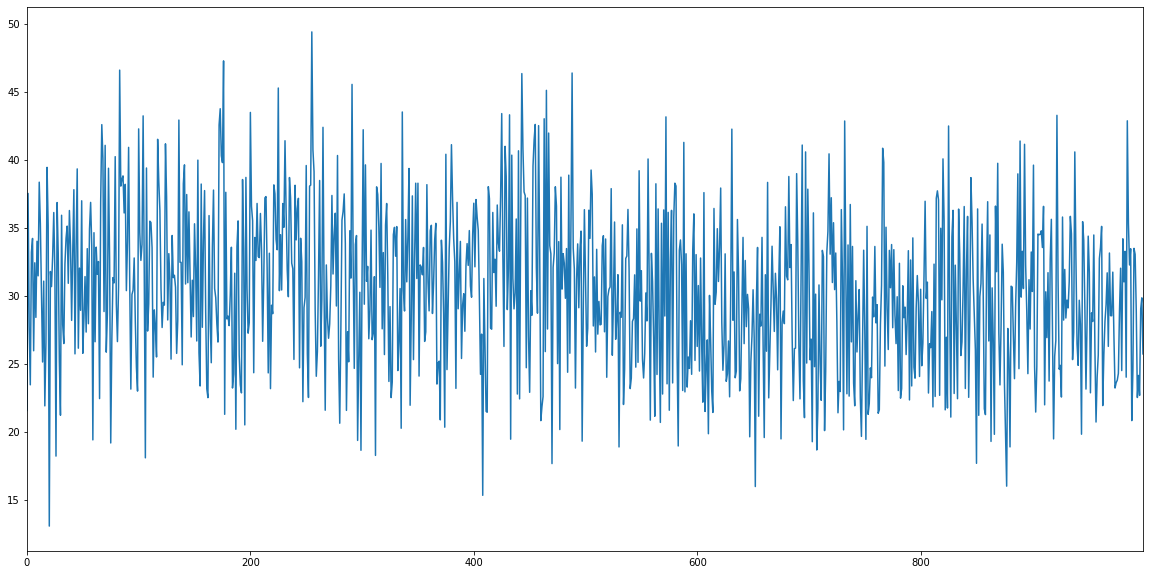

In [10]:
results_a[33].plot(figsize=(20,10)) #Turkey

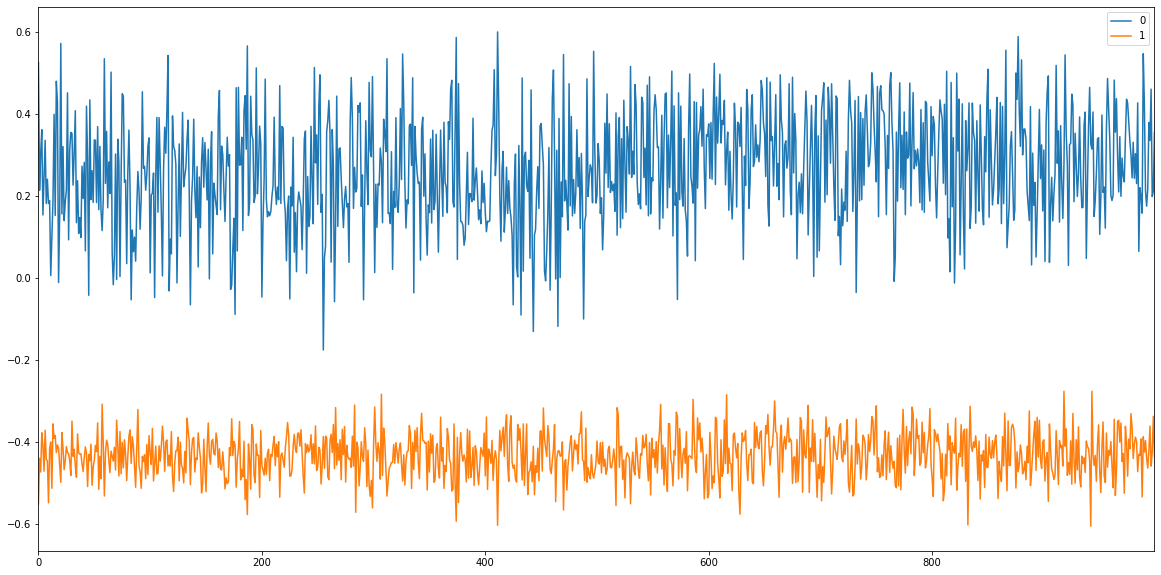

In [11]:
results_b.plot(figsize=(20,10))

### I don't know how to specify b[1] distribution.
### I don't know how to make the main explanatory variable very informative or far away.
### Theoretically I expect the post distribution to be determined more by the data when prior is not informative, and vice/versa.